# SYSID - Trabalho (ML - MISO.LM)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#sisidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.narmax_tools import regressor_code

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Autosklearn
from autosklearn.regression import AutoSklearnRegressor

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score

# Disabling warnings
import warnings
from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/data/volve_compiled.pkl


In [3]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


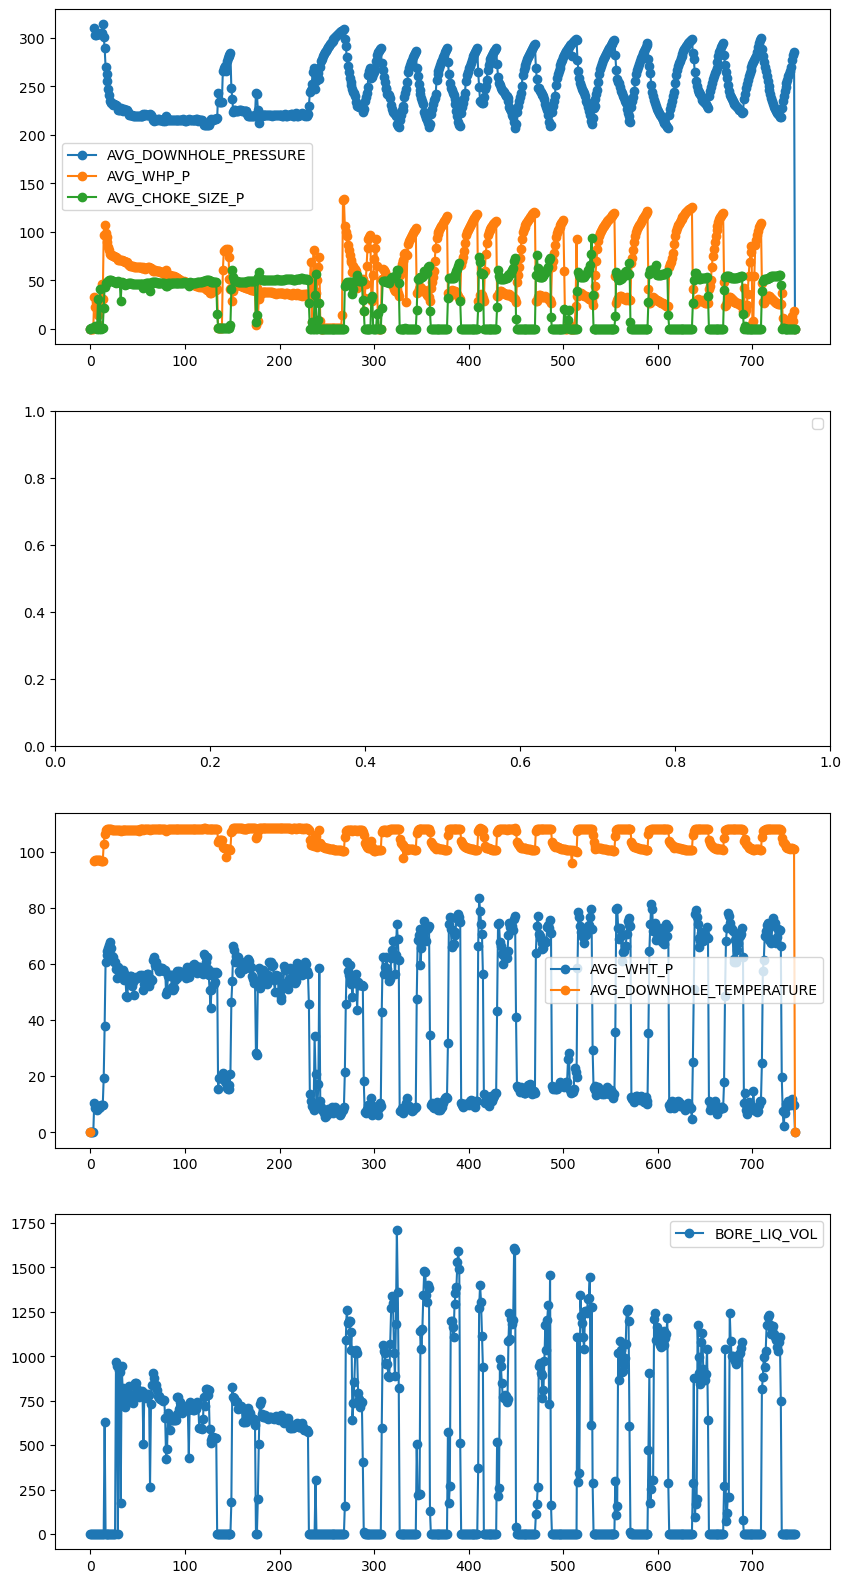

In [4]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [5]:
data_case = data_case.loc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [6]:
p_train = 0.7 #70% treino

### 1.2 - Separando os conjuntos

In [7]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[:,:]
y_te = y[:,:]

In [8]:
print(
    X1_tr.shape,
    X1_te.shape
)

(502, 5) (718, 5)


### 1.3 - Removendo a escala 

In [9]:
X_scale = MinMaxScaler()
y_scale = MinMaxScaler()
X_tr = X_scale.fit_transform(X1_tr)
X_te = X_scale.transform(X1_te)
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

## Passo 2 - Declarando os modelos 

In [10]:
models = []

### 2.1 - ARMAX (sysidentpy)

In [11]:
basis_function = Polynomial(degree=1)
n = 2
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 6
model = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    #extended_least_squares=True,
)

models.append(('ARMAX', model))

### 2.2 - NARMAX (sysidentpy)

In [12]:
basis_function = Fourier(degree=2)
n = 2
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 6
model = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    #extended_least_squares=True,
)
models.append(('NARMAX', model))

### 2.3 - Modelos de ML (sklearn)

#### 2.3.1 - Modelos

In [13]:
models_ml = [
    ('LinReg',  LinearRegression(copy_X=True)), #ARX Equivalent
    ('PolyReg', Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivalent
    ('SVM',     SVR(max_iter=-1)),
    ('KNN',     KNeighborsRegressor()),
    ('DT',      DecisionTreeRegressor(random_state=rs)),
    ('RF',      RandomForestRegressor(random_state=rs)),
]

#### 2.3.2 - Parâmetros (RandomSearchCV)

In [14]:
parameters = [
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        'Poly__degree'                : [2, 3, 4],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
]

In [15]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

In [16]:
n_iter = 100 #Numero de iterações do rdmsearch 

for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)
    
    sidmodel = SYSIDRegressor(
        nX=6, ny=6,
        estimator=rdmsearch, 
        preprocessor=MinMaxScaler(),
        #expansor=PolynomialFeatures(degree=2)
        )
    
    models.append(
        (model[0], sidmodel)
    )




### 2.4 - Autoskl models

In [17]:
models.append(
    ('AutoSkl',
        SYSIDRegressor(
            nX=6, ny=6,
            estimator=AutoSklearnRegressor(
                    tmp_folder="./autoskl-temp",
                    delete_tmp_folder_after_terminate=False,
                    n_jobs=6,
                    ),
            preprocessor=MinMaxScaler()
        )
    )
)

In [18]:
models = models[-1:]
n_models = len(models)

In [19]:
results = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
    'PARS':[],
}

order_progression = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
}

In [20]:
for model in models:
    print(model[0])

AutoSkl


Starting evaluation of model: AutoSkl
    Trying order: 2
[WARNING] [2022-11-12 08:31:03,085:Client-AutoML(1):7b3448b8-627d-11ed-90a1-00155dabe9b7] Capping the per_run_time_limit to 1799.0 to have time for a least 2 models in each process.


/home/pedro-linux/miniconda3/envs/autoskl-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/home/pedro-linux/miniconda3/envs/autoskl-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/home/pedro-linux/miniconda3/envs/autoskl-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/home/pedro-linux/miniconda3/envs/autoskl-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/home/pedro-linux/miniconda3/envs/autoskl-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overfl

        R2 score OSA (Train): 0.9335735811113585
        R2 score OSA (Test): 0.8908839973578244
        R2 score FS (Train): 0.589992158205408
        R2 score FS (Test): 0.5481152877951347
    Trying order: 3
[ERROR] [2022-11-12 09:37:04,221:Client-AutoML(1):b5a3adff-6286-11ed-90a1-00155dabe9b7] ./autoskl-temp/.auto-sklearn/start_time_1 already exist. Different seeds should be provided for different jobs.
Traceback (most recent call last):
  File "/home/pedro-linux/miniconda3/envs/autoskl-env/lib/python3.9/site-packages/autosklearn/automl.py", line 644, in fit
    self._backend.save_start_time(self._seed)
  File "/home/pedro-linux/miniconda3/envs/autoskl-env/lib/python3.9/site-packages/autosklearn/automl_common/common/utils/backend.py", line 255, in save_start_time
    raise ValueError(
ValueError: ./autoskl-temp/.auto-sklearn/start_time_1 already exist. Different seeds should be provided for different jobs.


ValueError: ./autoskl-temp/.auto-sklearn/start_time_1 already exist. Different seeds should be provided for different jobs.

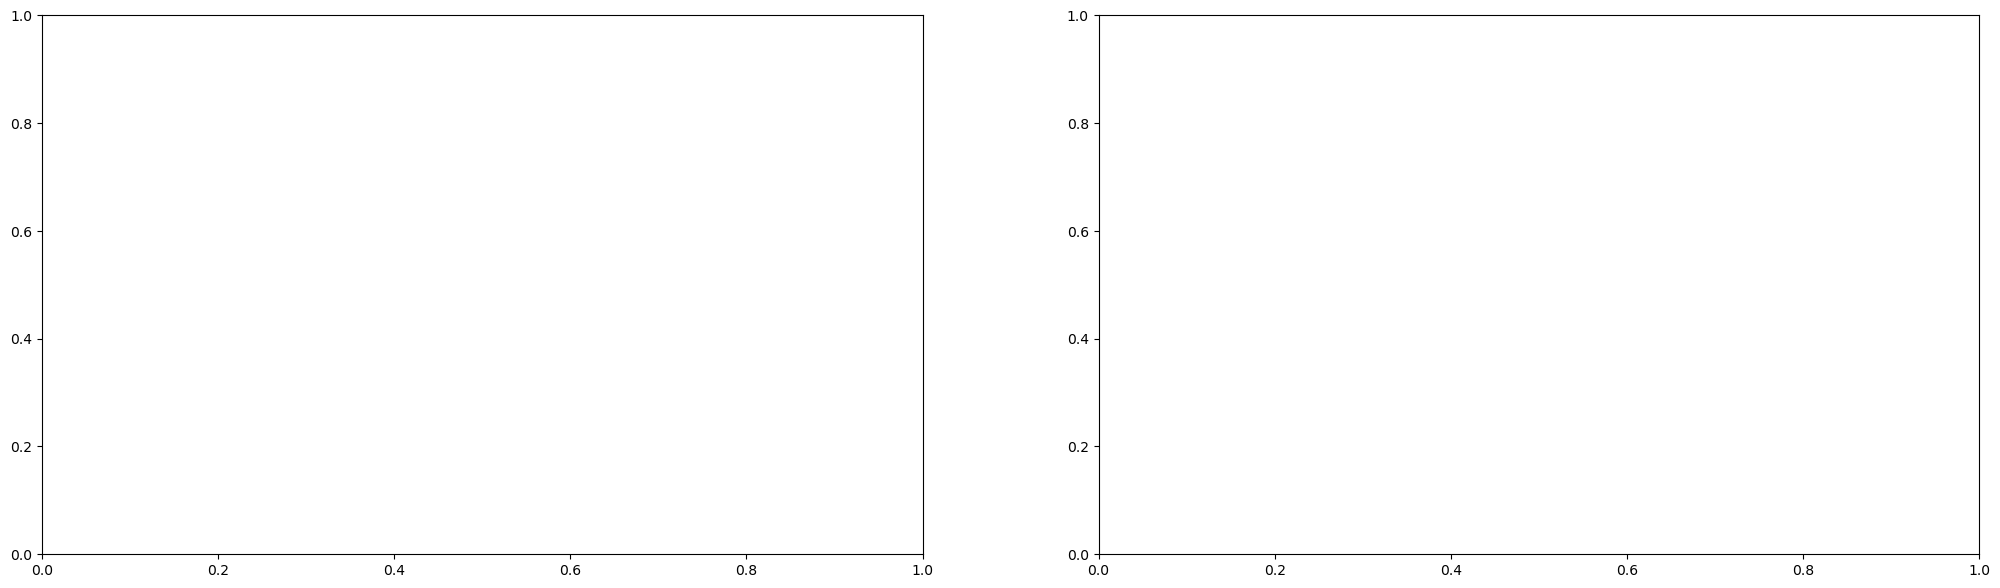

In [21]:

fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))
orders = range(2,21)
#Loop principal, iterando sobre as listas
for model, ax in zip(models, axs):
    
    model_name, sidmodel = model

    print('Starting evaluation of model: {}'.format(model_name))
    
    t0 = datetime.now()

    best_r2_tr_fs = 1e6
    best_r2_te_fs = 1e6
    best_r2_tr_osa = 1e6
    best_r2_te_osa = 1e6
    best_order = 0
    best_model = None
    
    for order in orders:
        print(f'    Trying order: {order}')
        if hasattr(sidmodel, 'nX') and model_name != 'AutoSkl': # is from our package
            sidmodel.nX = order
            sidmodel.ny = order
        elif model_name == 'AutoSkl':
            sidmodel = SYSIDRegressor(
                        nX=order, ny=order,
                        estimator=AutoSklearnRegressor(
                                tmp_folder=f"./autoskl-temp{order}",
                                delete_tmp_folder_after_terminate=False,
                                n_jobs=6,
                                    ),
                        preprocessor=MinMaxScaler()
            )
        else:
            sidmodel.xlag = [order]*X1_tr.shape[1]
            sidmodel.ylag = order
            sidmodel.elag = order
            regressors = regressor_code(X=X1_tr,
                                        xlag=[order]*X1_tr.shape[1],
                                        ylag=order,
                                        model_type="NARMAX",
                                        model_representation="neural_network",
                                        basis_function=sidmodel.basis_function
                                        )

            n_features = regressors.shape[0]
            
            #sidmodel.n_terms = n_features

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X=X1_tr, y=y_tr)
        r2_tr_osa = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1))
        r2_te_osa = r2_score(y_te, sidmodel.predict(X1_te, y=y_te, steps_ahead=1))
        r2_tr_fs = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr))
        r2_te_fs = r2_score(y_te, sidmodel.predict(X1_te, y=y_te))
        if np.abs(r2_tr_fs - 1) < np.abs(best_r2_tr_fs - 1):
            best_r2_tr_fs = r2_tr_fs
            best_r2_te_fs = r2_te_fs
            best_r2_tr_osa = r2_tr_osa
            best_r2_te_osa = r2_te_osa
            best_order = order
            best_model = sidmodel
        order_progression['MODEL'].append(model_name)
        order_progression['ORDER'].append(order)
        order_progression['R2 TRAIN OSA'].append(r2_tr_osa)
        order_progression['R2 TEST OSA'].append(r2_te_osa)
        order_progression['R2 TRAIN FS'].append(r2_tr_fs)
        order_progression['R2 TEST FS'].append(r2_te_fs)
        order_progression['MODEL OBJ'].append(sidmodel)
        print('        R2 score OSA (Train):', r2_tr_osa)
        print('        R2 score OSA (Test):', r2_te_osa)
        print('        R2 score FS (Train):', r2_tr_fs)
        print('        R2 score FS (Test):', r2_te_fs)
        
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Best Order:', best_order)
    print('    R2 score OSA (Train):', best_r2_tr_osa)
    print('    R2 score OSA (Test):', best_r2_te_osa)
    print('    R2 score FS (Train):', best_r2_tr_fs)
    print('    R2 score FS (Test):', best_r2_te_fs)

    hist = ax[0].plot(y_tr, label='Train')
    hist = ax[0].plot(sidmodel.predict(X1_tr, y=y_tr), label='Model') 
    ax[0].set_title(f'{model_name}: Train fit')
    ax[0].legend()
    hist = ax[1].plot(y_te[n_train:,:], label='Test')
    hist = ax[1].plot(sidmodel.predict(X1_te, y=y_te)[n_train:,:], label='Model')
    ax[1].set_title(f'{model_name}: Full life prediction')
    ax[1].legend()
    print()
    
    results['MODEL'].append(model_name) 
    results['ORDER'].append(best_order)
    results['R2 TRAIN OSA'].append(best_r2_tr_osa)
    results['R2 TEST OSA'].append(best_r2_te_osa)
    results['R2 TRAIN FS'].append(best_r2_tr_fs)
    results['R2 TEST FS'].append(best_r2_te_fs)
    results['MODEL OBJ'].append(sidmodel)
    try:
        results['PARS'].append(sidmodel.estimator.best_params_)
    except Exception:
        results['PARS'].append(sidmodel.final_model)

In [ ]:
pd.DataFrame(results)

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ,PARS
0,ARMAX,11,0.758957,0.760379,-0.088821,-0.087812,<sysidentpy.model_structure_selection.forward_...,"[[1001], [2001], [2004], [0], [2005], [2003]]"
1,NARMAX,2,0.780825,0.772464,0.616217,0.601519,<sysidentpy.model_structure_selection.forward_...,"[[4002, 1002], [3010, 0], [3003, 1003], [3006,..."
2,LinReg,4,0.803836,0.795057,0.584551,0.592395,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'positive': True}
3,PolyReg,5,0.821202,0.810080,0.655108,0.662723,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'Reg__positive': True}
4,SVM,12,0.816499,0.799001,0.623149,0.634136,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'C': 11.272575863403866, 'degree': 5, 'gamma'..."
5,KNN,14,1.000000,0.896837,0.694380,0.651588,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'n_neighbors': 5, 'weights': 'distance'}"
6,DT,10,0.818336,0.763038,0.628380,0.634306,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 16, 'max_features': 0.9868299345..."
7,RF,6,0.922930,0.875412,0.732803,0.704310,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 7, 'max_features': 0.63893978454..."


In [ ]:
order_progression = pd.DataFrame(order_progression)
order_progression

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ
0,ARMAX,2,0.764163,0.758294,-202.334814,-195.360214,<sysidentpy.model_structure_selection.forward_...
1,ARMAX,3,0.743791,0.748160,-745.303495,-696.163574,<sysidentpy.model_structure_selection.forward_...
2,ARMAX,4,0.747202,0.756769,-532.554143,-494.972925,<sysidentpy.model_structure_selection.forward_...
3,ARMAX,5,0.736458,0.754493,-2738.524333,-2709.145318,<sysidentpy.model_structure_selection.forward_...
4,ARMAX,6,0.760238,0.768703,-19.406413,-20.040432,<sysidentpy.model_structure_selection.forward_...
...,...,...,...,...,...,...,...
99,RF,10,0.954052,0.896815,0.728912,0.701527,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
100,RF,11,0.953977,0.898863,0.725443,0.700948,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
101,RF,12,0.942074,0.892813,0.706471,0.682017,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
102,RF,13,0.942313,0.893884,0.707218,0.685996,SYSIDRegressor(estimator=RandomizedSearchCV(cv...


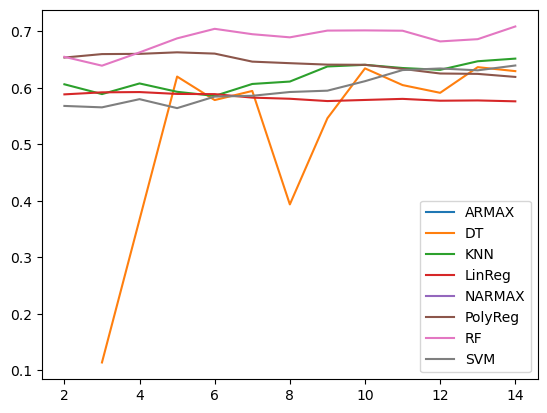

In [ ]:
fig, ax = plt.subplots()
for model in np.unique(order_progression.MODEL):
    #if model == 'DT': continue
    data_filt = order_progression[order_progression.MODEL == model]
    data_filt = data_filt[data_filt['R2 TEST FS'] >= 0]
    ax.plot(data_filt.ORDER, data_filt['R2 TEST FS'], label=model)
ax.legend()